# SVM classification/SMOTE oversampling for an imbalanced data set

Date created: Oct 14, 2016   
Last modified: Oct 14, 2016  
Tags: SVM, SMOTE, ROC/AUC, oversampling, imbalanced data set, semiconductor data   
About: Rebalance imbalanced semicondutor manufacturing dataset by oversampling the minority class using SMOTE. Classify using SVM. Assess the value of oversampling using ROC/AUC. 

<h3>I. Introduction</h3>

The [SECOM dataset](http://archive.ics.uci.edu/ml/datasets/SECOM) in the  [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml) is semicondutor manufacturing data. There are 1567 records, 590 anonymized features and 104 fails. This makes it an imbalanced dataset with a 14:1 ratio of pass to fails. The process yield has a simple pass/fail response (encoded -1/1).

<h4>Objective</h4>
We consider some of the different approaches to classify imbalanced data. In the [previous example](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_ocsvm.ipynb) we looked at one-class SVM.
Another strategy is to rebalance the dataset by oversampling the minority class and/or undersampling the majority class. This is done to improve the sensitivity (i.e the true positive rate) of the minority class. For this exercise, we will look at: 
- rebalancing the dataset using SMOTE (which oversamples the minority class) 
- ROC curves for different oversampling ratios
 

<h4>Methodology</h4>
The *sklearn* [imblearn toolbox](http://contrib.scikit-learn.org/imbalanced-learn/index.html) has many methods for oversamplng/undersampling. We will use the SMOTE (Synthetic Minority Over-sampling Technique) method introduced in 2002 by Chawla et al. <a href="#ref1">[1]</a>, <a href="#ref2">[2]</a>. With SMOTE, synthetic examples are interpolated along the line segments joining some/all of the <i>k</i> minority class nearest neighbors.  
In the experiment, the  oversampling rate is varied between 10-70%, in 10% increments. The percentage represents the final minority class fraction after oversampling: if the majority class has 1000 data points (and the minority class 50), at 10% the minority class will have 100 data points after oversampling (not 5 or 50+5 = 55). 

The rebalanced data is classified using an SVM. The *imblearn* toolbox has a *pipeline* method which will be used to chain all the steps. The SMOTE+SVM method is evaluated by the area under the Receiver Operating Characteristic curve (AUC).

<h4>Preprocessing</h4>
The data represents measurements from a large number of processes or sensors and many of the records are missing. In addition some measurements are identical/constant and so not useful for prediction. We will remove those columns with high missing count or constant values.  
The Random Forest variable importance is used to rank the variables in terms of their importance. For the random forest, we will impute the remainaing missing values with the median for the column.   
We will additionally scale the data that is applied to the SVM. We will use the <i>sklearn preprocessing</i> module for both imputing and scaling.
These are the same steps used for the [one-class SVM](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_ocsvm.ipynb) and a more detailed explanation can be seen there. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split as tts

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc

from __future__ import division

In [2]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
secom = pd.read_table(url, header=None, delim_whitespace=True)

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
y = pd.read_table(url, header=None, usecols=[0], squeeze=True, delim_whitespace=True)

print 'The dataset has {} observations/rows and {} variables/columns.' \
       .format(secom.shape[0], secom.shape[1])
print 'The ratio of majority class to minority class is {}:1.' \
      .format(int(y[y == -1].size/y[y == 1].size))

The dataset has 1567 observations/rows and 590 variables/columns.
The ratio of majority class to minority class is 14:1.


<h3>II. Preprocessing </h3>

We process the missing values first, dropping columns which have a large number of missing values and imputing values for those that have only a few missing values.
The Random Forest variable importance is used to rank the variables in terms of their importance. The [one-class SVM](https://github.com/Meena-Mani/SECOM_class_imbalance/blob/master/secomdata_ocsvm.ipynb) exercise has a more detailed version of these steps.

In [3]:
# dropping columns which have large number of missing entries 

m = map(lambda x: sum(secom[x].isnull()), xrange(secom.shape[1]))
m_200thresh = filter(lambda i: (m[i] > 200), xrange(secom.shape[1]))
secom_drop_200thresh = secom.dropna(subset=[m_200thresh], axis=1)
dropthese = [x for x in secom_drop_200thresh.columns.values if \
             secom_drop_200thresh[x].std() == 0]
secom_drop_200thresh.drop(dropthese, axis=1, inplace=True)

print 'The SECOM data set now has {} variables.'\
      .format(secom_drop_200thresh.shape[1])
    

The SECOM data set now has 409 variables.


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# imputing missing values for the random forest

imp = Imputer(missing_values='NaN', strategy='median', axis=0)
secom_imp = pd.DataFrame(imp.fit_transform(secom_drop_200thresh))

# use Random Forest to assess variable importance

rf = RandomForestClassifier(n_estimators=100, random_state=7)
rf.fit(secom_imp, y)

# sorting features according to their rank

importance = rf.feature_importances_
ranked_indices = np.argsort(importance)[::-1]


<h3>III. SVM Classification </h3>

<h4> Preprocessing </h4>

The SVM is sensitive to feature scale so the first step is to center and normalize the data. The train and test sets are scaled separately using the mean and variance computed from the training data. This is done to estimate the ability of the model to generalize.


In [6]:
# split data into train and holdout sets
# stratify the sample used for modeling to preserve the class proportions


X_train, X_holdout, y_train, y_holdout = tts(secom_imp[ranked_indices[:40]], y, \
                                             test_size=0.2, stratify=y, random_state=5)


print 'Train data: The majority/minority class have {} and {} elements respectively.'\
      .format(y_train[y_train == -1].size, y_train[y_train == 1].size)
print 'The maj/min class ratio is: {0:2.0f}' \
      .format(round(y_train[y_train == -1].size/y_train[y_train == 1].size))
print 'Holdout data: The majority/minority class have {} and {} elements respectively.'\
       .format(y_holdout[y_holdout == -1].size, y_holdout[y_holdout == 1].size)
print 'The maj/min class ratio for the holdout set is: {0:2.0f}' \
      .format(round(y_holdout[y_holdout == -1].size/y_holdout[y_holdout == 1].size))
    

Train data: The majority/minority class have 1170 and 83 elements respectively.
The maj/min class ratio is: 14
Holdout data: The majority/minority class have 293 and 21 elements respectively.
The maj/min class ratio for the holdout set is: 14


In [7]:
# scaling the split data. The holdout data uses scaling parameters 
# computed from the training data

standard_scaler  = StandardScaler()
X_train_scaled = pd.DataFrame(standard_scaler.fit_transform(X_train), \
                              index=X_train.index)
X_holdout_scaled = pd.DataFrame(standard_scaler.transform(X_holdout))

<h4> Finding parameters </h4>

The usual way to select parameters is via grid-search and cross-validation (CV). The scoring is based on the accuracy. With imbalanced classes, since the true positive of the majority class dominates, alternative [scoring measures](http://scikit-learn.org/stable/modules/model_evaluation.html) such as the [F1](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) and [$F_{\beta}$](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) scores or the [Matthews Correlation Coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html), which uses all four values of the confusion matrix, are used.   
In CV experiments on this data, the majority class still dominates so that for the best CV F1-scores, the True Negative Rate (TNR - the rate at which the minority class is correctly classified) is zero.  
Instead of automating the selection of hyperparameters, I have manually selected C and gamma values for which the precision/recall/F1 values as well as the TNR are high.

An example is shown below.

In [8]:
# oversampling
ratio = 0.5

smote = SMOTE(ratio = ratio, kind='regular')
smox, smoy = smote.fit_sample(X_train_scaled, y_train)

print 'Before resampling: \n\
The majority/minority class have {} and {} elements respectively.'\
.format(y_train[y == -1].size, y_train[y == 1].size)
print 'After oversampling at {}%: \n\
The majority/minority class have {} and {} elements respectively.'\
.format(ratio, smoy[smoy == -1].size, smoy[smoy == 1].size)


Before resampling: 
The majority/minority class have 1170 and 83 elements respectively.
After oversampling at 0.5%: 
The majority/minority class have 1170 and 585 elements respectively.


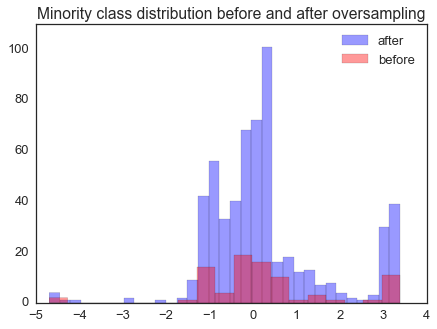

In [29]:
# plotting minority class distribution after SMOTE

sns.set(style="white", font_scale=1.3) 
fig, ax = plt.subplots(figsize=(7,5))

after = pd.DataFrame(smox)

ax = sns.distplot(after[4][smoy == 1], color='b',  \
                  kde=False, label='after')         
ax = sns.distplot(X_train_scaled[4][y_train == 1], color='r', \
                  kde=False, label='before')
ax.set_ylim([0, 110])
ax.set(xlabel='')
ax.legend()
plt.title('Minority class distribution before and after oversampling')

plt.show()

In [34]:
# classification results
from sklearn.metrics import confusion_matrix, classification_report,\
roc_auc_score, accuracy_score

clf = SVC(C = 2, gamma = .0008)
clf.fit(smox, smoy)
y_predicted = clf.predict(X_holdout_scaled)


print 'The accuracy is: {0:4.2} \n' .format(accuracy_score(y_holdout, y_predicted))

print 'The confusion matrix: '
cm = confusion_matrix(y_holdout, y_predicted)
print cm
print 'The True Negative rate is: {0:4.2} \n' .format(float(cm[1][1])/np.sum(cm[1]))
print(classification_report(y_holdout, y_predicted))
print 'The AUC is: {0:4.2}'.format(roc_auc_score(y_holdout, y_predicted))


The accuracy is: 0.85 

The confusion matrix: 
[[260  33]
 [ 14   7]]
The True Negative rate is: 0.33 

             precision    recall  f1-score   support

         -1       0.95      0.89      0.92       293
          1       0.17      0.33      0.23        21

avg / total       0.90      0.85      0.87       314

The AUC is: 0.61


Here the TNR is 0.33 and the precision/recall/F1 is in the 0.85 - 0.90 range. Whereas selecting the best CV score (usually in the 0.90 range) would have given a TNR or 0 for all the scoring metrics I looked at.

<h4>The Pipeline -- Oversampling, classification and ROC computations </h4>

The *imblearn package* includes a [pipeline](http://contrib.scikit-learn.org/imbalanced-learn/generated/imblearn.pipeline.Pipeline.html#imblearn.pipeline.Pipeline) module which allows one to chain transformers, resamplers and estimators. We compute the ROC curves for each of the oversampling ratios and corresponding hyperparameters C and gamma and for this we use the pipeline to oversample with SMOTE and classify with the SVM.


In [31]:
# oversampling, classification and computing ROC values

fpr = dict()
tpr = dict()
roc_auc = dict()

ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
C =     [3, 3, 3, 2, 2, 2, 2]
gamma = [.02, .009, .009, .005, .0008, .0009, .0007]

    
estimators = [('smt', SMOTE(random_state=42)), 
              ('clf', SVC(probability=True, random_state=42))]
pipe = Pipeline(estimators)

print pipe

for i, ratio, C, gamma in zip(range(7), ratio, C, gamma):

    pipe.set_params(smt__ratio = ratio, clf__C = C, clf__gamma = gamma)
    probas_ = pipe.fit(X_train_scaled, y_train).predict_proba(X_holdout_scaled)
    fpr[i], tpr[i], _ = roc_curve(y_holdout, probas_[:,1])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

Pipeline(steps=[('smt', SMOTE(k=5, kind='regular', m=10, n_jobs=-1, out_step=0.5, random_state=42,
   ratio='auto')), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


In [32]:
# plotting the ROC curves

def plot_roc(fpr, tpr, roc_auc):
    colors = ['darkorange', 'deeppink', 'red', 'aqua', 'cornflowerblue','navy', 'blue']

    plt.figure(figsize=(10,8.5))
    for i, color in zip(range(7), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, linestyle=':',
                 label='{0} (area = {1:0.2f})'
                 ''.format((i+1)/10, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves: SMOTE oversampled minority class', fontsize=14)
    plt.legend(title='Class ratio after oversampling', loc="lower right")
    plt.show()
#   plt.savefig('ROC_oversampling.png')


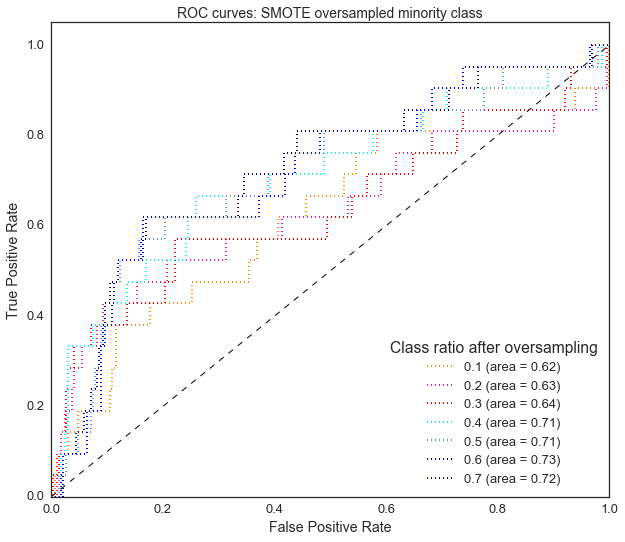

In [33]:
plot_roc(fpr, tpr, roc_auc)

<h3>IV. Discussion</h3>

There is a trend in the ROC curves (the ROC convex hull) in the figure above with higher oversampling ratios --0.7 vs 0.1-- having a higher AUC. An obvious question then is whether increasing the oversampling ratio to  get a balanced data set would give the best results.  

In the experiment, no significant improvements were seen in the 0.5 - 0.8 (0.8 not plotted) regime. Oversampling with SMOTE broadens the decision region around the minority points (so we would expect better results) but the coverage may exceed the decision surface<sup>**</sup>. The level of oversampling therefore needs to be experimentally determined. 

Another strategy to balance the classes is to combine oversampling (the minority class) with undersampling (the majority class). Chawla et al. had reported <a href="#ref1">[1]</a> that a combination of oversampling and undersampling gave the best results. We will experiment with this combination in a future exercise.


<sup>**</sup>It should also be noted that oversampling results in a significant increase (and bias) in the minority class. For instance, for a 0.5 ratio, the minority class is increased seven-fold (from 83 to 585). A completely balanced data set would involve a fourteen-fold increase in the minority class and this would alter the decision surface.

<h3>V. References and Further Reading </h3>

<a name="ref1"></a>[1] [Nitesh V. Chawla, Kevin W. Bowyer, Lawrence O. Hall, and W. Philip Kegelmeyer. SMOTE: synthetic minority over-sampling technique. J. Artif. Int. Res. 16, 1 (June 2002), 321-357. ](https://www.cs.cmu.edu/afs/cs/project/jair/pub/volume16/chawla02a-html/chawla2002.html)

<a name="ref2"></a>[2] [Chawla, Nitesh V.  Data Mining for Imbalanced Datasets: An Overview. In: Maimon, Oded; Rokach, Lior (Eds) Data Mining and Knowledge Discovery Handbook, Springer, (2010), 875-886.](http://www3.nd.edu/~dial/publications/chawla2005data.pdf)

<a name="ref3"></a>[3] [Altini, Marco. "Dealing with Imbalanced Data: Undersampling, Oversampling and Proper Cross-validation." Web log post. Marco Altini Blog. N.p., 17 Aug. 2015. Web.](http://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation)


<div style="background-color: #FAAC58; margin-left: 0px; margin-right: 20px; padding-bottom: 8px; padding-left: 8px; padding-right: 8px; padding-top: 8px;">


Author:  Meena Mani  <br>
email:   meenas.mailbag@gmail.com   <br> 
twitter: @meena_uvaca    <br>
</div>